In [2]:
import numpy as np
import matplotlib.pyplot as plt
#scipy cwt
import scipy
import sys
import os
from ssqueezepy import ssq_cwt
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.getcwd()) + "/../../../../.")

from wavelib.python.wavelibh import WavelibH
wavelib_as = WavelibH('../../../../../wavelib/python/libwavelibwrapper.so')


def exponential_smoothing(data, alpha):
    smoothed_data = np.zeros_like(data)
    smoothed_data[0] = data[0]  # Initial condition

    for t in range(1, len(data)):
        smoothed_data[t] = alpha * data[t] + (1 - alpha) * smoothed_data[t-1]

    return smoothed_data

SCALES = 12 #cwt scales
MORLET = 5
SAMPLE_LEN = 200
DECIMATION = 2 #by how much to decimate the signal of 20khz

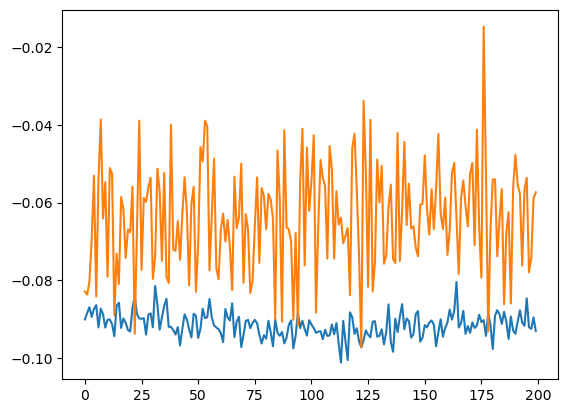

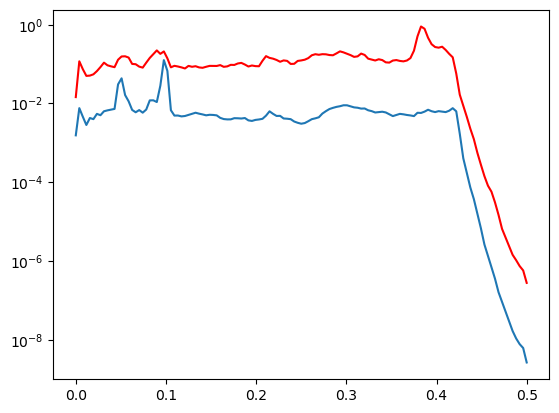

In [3]:
all_normal_signal = np.loadtxt('exp1_b3_ch5_first100k.txt')
all_fault_signal = np.loadtxt('exp1_b3_ch5_last100k.txt')

#first decimate the signals by 2
all_normal_signal = scipy.signal.decimate(all_normal_signal, DECIMATION)
all_fault_signal = scipy.signal.decimate(all_fault_signal, DECIMATION)

smooth_all_normal_signal = exponential_smoothing(all_normal_signal, 1) #1 means no smoothing --> this yields best results
smooth_all_fault_signal = exponential_smoothing(all_fault_signal, 1)


#extract windows of 200 samples from the smoothed signals
normal_signals = []
fault_signals = []
for i in range(0, len(smooth_all_normal_signal)-SAMPLE_LEN, SAMPLE_LEN):
    normal_signals.append(smooth_all_normal_signal[i:i+SAMPLE_LEN])
    fault_signals.append(smooth_all_fault_signal[i:i+SAMPLE_LEN])
    


mean_normal_signal = np.mean(np.array(normal_signals),axis=0)
mean_fault_signal = np.mean(np.array(fault_signals),axis=0)

plt.plot(mean_normal_signal)
plt.plot(mean_fault_signal)

plt.figure()
#plot psd of the mean signals
f, Pxx_den = scipy.signal.welch(smooth_all_normal_signal, fs=1)
plt.semilogy(f, Pxx_den)
f, Pxx_den = scipy.signal.welch(smooth_all_fault_signal, fs=1)
plt.semilogy(f, Pxx_den, 'r')

### Copy to micro

In [4]:
# for C header file
cstring = "//generated by python script\n //params: SCALES=%d, MORLET=%d, SAMPLE_LEN=%d\n" % (SCALES, MORLET, SAMPLE_LEN)
# prolog
cstring += ('double mean_normal_signal[%d] = {' % (int(SAMPLE_LEN)))
for element in mean_normal_signal:
    cstring += ('%f,' % float(element))
# epilog
cstring += ('};\n')

cstring += ('double mean_fault_signal[%d] = {' % (int(SAMPLE_LEN)))
for element in mean_fault_signal:
    cstring += ('%f,' % float(element))
# epilog
cstring += ('};')

#copy to clipboard
import pyperclip
pyperclip.copy(cstring)

compare scipy output with: https://rafat.github.io/wavelib/#/cdisplay

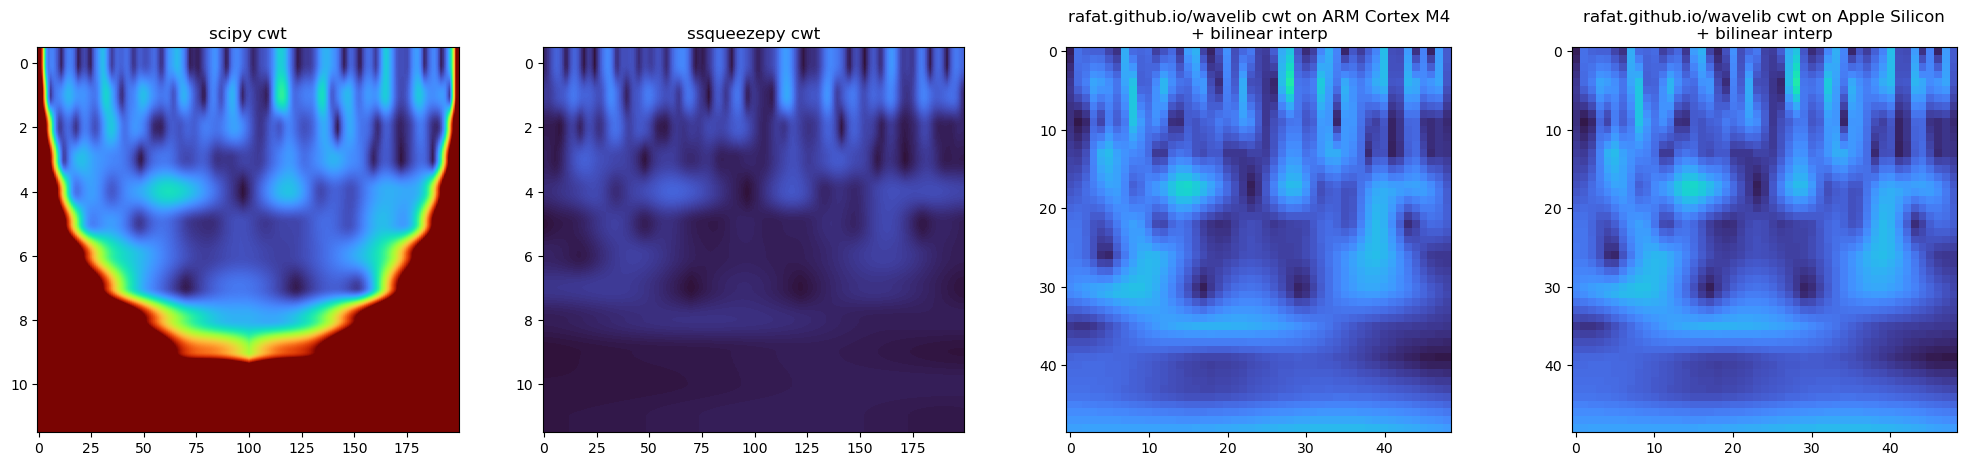

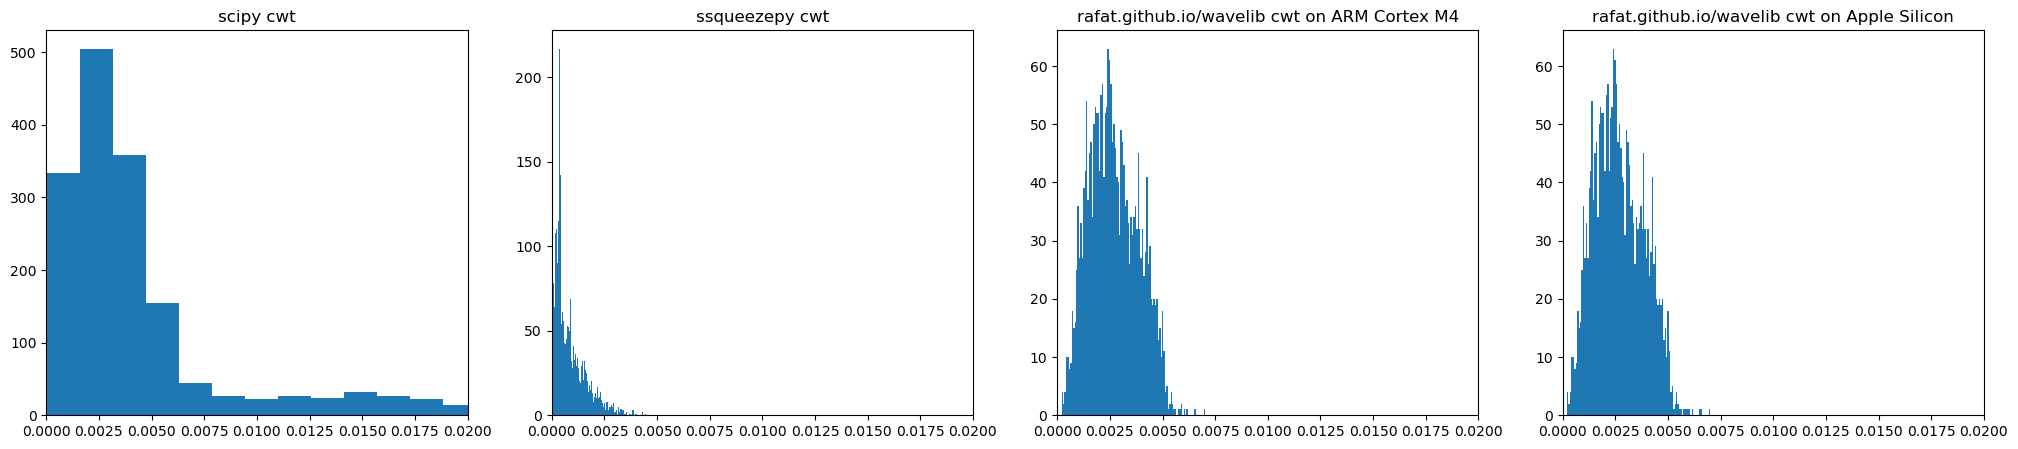

In [14]:
def plot_cwts(signal, wavelib=False, normal=True):    
    morlet_mu = MORLET
    dt=1
    wavelib_scales = np.array([2.000000, 2.804027, 3.931282, 5.511710, 7.727491, 10.834045, 15.189475, 21.295845, 29.857058, 41.859991, 58.688264, 82.281725,]) #wavelib generates this for us, we extracted it from the microcontroller
    wavelib_dj = 0.487500 #Separation between scales. eg., scale = s0 * 2 ^ ( [0:N-1] *dj ) or scale = s0 *[0:N-1] * dj
    wavelib_J = SCALES #scales
    
    ssqcwt_scales = np.exp(np.linspace(np.log(wavelib_scales)[0], np.log(wavelib_scales)[-1], SCALES)) #= log(wavelib_scales)

    wavelib_as_re, wavelib_as_im = wavelib_as.cwt(signal, morlet_mu, dt, wavelib_J)
    wavelib_as_mag = np.sqrt(wavelib_as_re**2 + wavelib_as_im**2)


    scipy_cwt = scipy.signal.cwt(signal, scipy.signal.morlet2,widths=wavelib_scales, w=morlet_mu)
    scipy_cwt = np.abs(scipy_cwt)

    if wavelib:
        if normal:
            wavelib_cwt = np.loadtxt("cwt_output_bearings_avg_normal.txt")
        else:
            wavelib_cwt = np.loadtxt("cwt_output_bearings_avg_fault.txt")
        
        wavelib_cwt = wavelib_cwt.reshape((wavelib_J,SAMPLE_LEN))
        


    t, w, *_= ssq_cwt(signal, ('morlet', {'mu': morlet_mu}), scales = ssqcwt_scales)
    w = np.abs(w)

    ################################################################################################################
    #                                                  plot CWT 
    ################################################################################################################
    #make a subplot, scipy on left, rafat.github.io/wavelib on right (with titles)
    plt.figure(figsize=(25, 5))
    plt.subplot(1, 4, 1)
    plt.title('scipy cwt')
    plt.imshow(scipy_cwt, aspect='auto', cmap='turbo', vmin=0, vmax=0.02)

    #ssq cwt
    plt.subplot(1, 4, 2)
    plt.title('ssqueezepy cwt')
    plt.imshow(w, aspect='auto', cmap='turbo', vmin=0, vmax=0.02)
    

    if wavelib:

        plt.subplot(1, 4, 3)
        plt.title('rafat.github.io/wavelib cwt on ARM Cortex M4\n+ bilinear interp')

        wavelib_cwt = wavelib_as.bilinear_interpolate(wavelib_cwt.flatten(), SCALES, SAMPLE_LEN, 49, 49)
        plt.imshow(wavelib_cwt, cmap='turbo', vmin=0, vmax=0.02, interpolation='none')
        
        
        plt.subplot(1, 4, 4)
        plt.title('rafat.github.io/wavelib cwt on Apple Silicon\n+ bilinear interp')
        
        wavelib_as_mag = wavelib_as.bilinear_interpolate(wavelib_as_mag.flatten(), SCALES, SAMPLE_LEN, 49, 49)
        plt.imshow(wavelib_as_mag, cmap='turbo', vmin=0, vmax=0.02, interpolation='none')

        #y axis is 0 = nyquist frequency, >8 small freqs
        #x axis is time


    ################################################################################################################
    #                                             plot histograms
    ################################################################################################################
    plt.figure(figsize=(25, 5))
    plt.subplot(1, 4, 1)
    plt.title('scipy cwt')
    plt.hist(scipy_cwt.flatten(), bins=100)
    plt.xlim([0, 0.02])


    plt.subplot(1, 4, 2)
    plt.title('ssqueezepy cwt')
    plt.hist(w.flatten(), bins=100)
    plt.xlim([0, 0.02])
    
        
    if wavelib:
        plt.subplot(1, 4, 3)
        plt.title('rafat.github.io/wavelib cwt on ARM Cortex M4')
        plt.hist(wavelib_cwt.flatten(), bins=100)
        #x axis limit
        plt.xlim([0, 0.02])
        
        plt.subplot(1, 4, 4)
        plt.title('rafat.github.io/wavelib cwt on Apple Silicon')
        plt.hist(wavelib_as_mag.flatten(), bins=100)
        #x axis limit
        plt.xlim([0, 0.02])

plot_cwts(mean_normal_signal, wavelib=True, normal=True)
plot_cwts(mean_fault_signal, wavelib=True, normal=False)
